数据列名: {'RECEIPT_NUMBER', 'BEN_PFIELD_OF_STUDY', 'FULL_TIME_IND', 'WORKSITE_ZIP', 'mail_addr', 'S1Q1B', 'BEN_COMP_PAID', 'ben_date_of_birth', 'WAGE_UNIT', 'valid_to', 'BEN_COUNTRY_OF_BIRTH', 'NUMBER_OF_BENEFICIARIES', 'WORKSITE_STATE', 'gender', 'DOL_ETA_CASE_NUMBER', 'S4Q1', 'first_decision_date', 'agent_first_name', 'bcn', 'country_of_birth', 'WAGE_AMT', 'zip', 'ben_year_of_birth', 'DOT_CODE', 'lottery_year', 'REQUESTED_CLASS', 'JOB_TITLE', 'NUM_OF_EMP_IN_US', 'FEIN', 'S3Q1', 'BASIS_FOR_CLASSIFICATION', 'T_U_VAWA_FLAG', 'country_of_nationality', 'PET_STREET', 'NAICS_CODE', 'PET_STATE', 'BEN_CURRENT_CLASS', 'PET_ZIP', 'i129_employer_name', 'rec_date', 'state', 'BEN_SEX', 'city', 'valid_from', 'REQUESTED_ACTION', 'FIRST_DECISION', 'status_type', 'agent_last_name', 'PET_CITY', 'WORKSITE_STREET', 'ED_LEVEL_DEFINITION', 'employer_name', 'WORKSITE_CITY', 'S1Q1A', 'ben_multi_reg_ind', 'BEN_EDUCATION_CODE'}
训练集目标变量分布:
FIRST_DECISION
1    1963
0      35
Name: count, dtype: int64
测试集目标变量分布:
FIR

<ipython-input-3-c8fcde391301>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # 前向填充
<ipython-input-3-c8fcde391301>:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)  # 后向填充
<ipython-input-3-c8fcde391301>:42: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data.fillna(method='ffill', inplace=True)
<ipython-input-3-c8fcde391301>:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data.fillna(method='bfill', inplace=True)
<ipython-input-3-c8fcde391301>:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series t

[LightGBM] [Info] Number of positive: 1963, number of negative: 35
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 1998, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.982482 -> initscore=4.026881
[LightGBM] [Info] Start training from score 4.026881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM 评估:
Accuracy: 0.9299, Precision: 0.9327, Recall: 0.9968, F1-score: 0.9637, AUC-ROC: 0.4309
Logistic Regression 评估:
Accuracy: 0.9329, Precision: 0.9329, Recall: 1.0000, F1-score: 0.9653, AUC-ROC: 0.4846


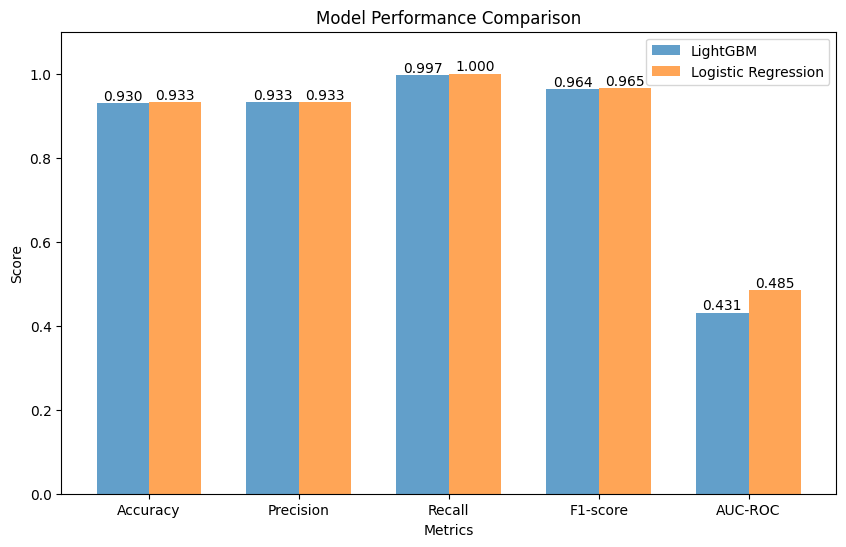

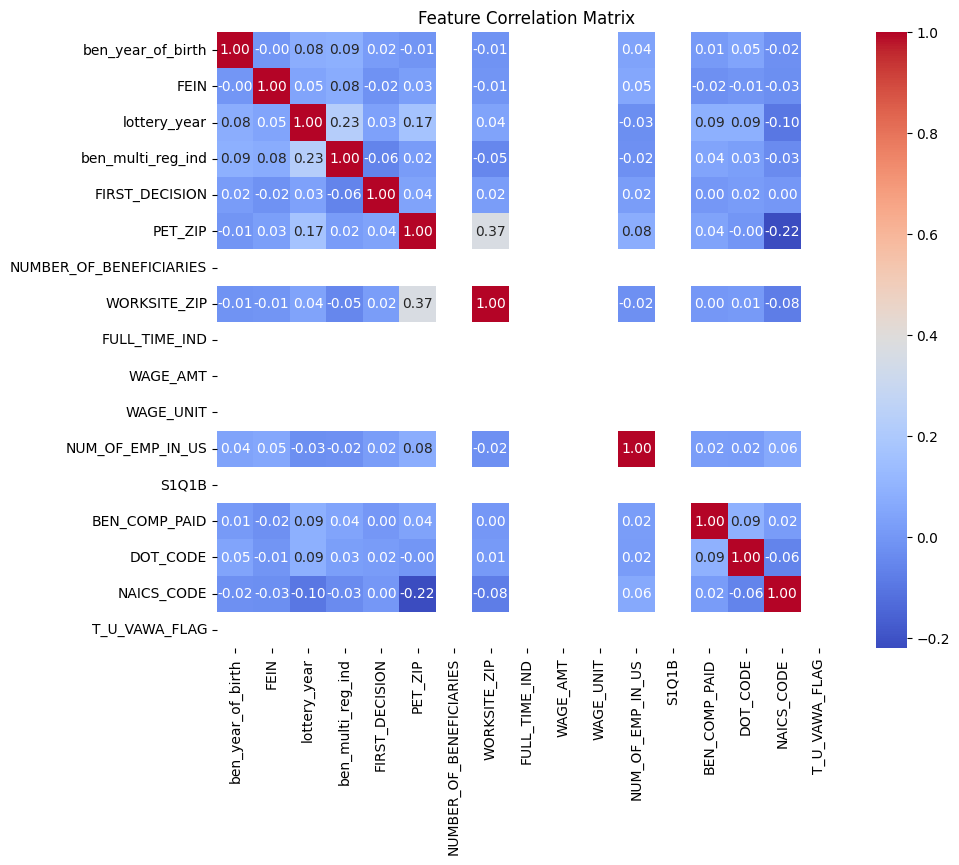

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 1. 读取数据
file_paths = {
    "2021": "2021.xlsx",
    "2022": "2022.xlsx",
    "2023": "2023.xlsx"
}

data_2021 = pd.read_excel(file_paths["2021"])
data_2022 = pd.read_excel(file_paths["2022"])
data_2023 = pd.read_excel(file_paths["2023"])

# 查看列名
data_columns = set(data_2021.columns) & set(data_2022.columns) & set(data_2023.columns)
print("数据列名:", data_columns)

# 目标变量
target = 'FIRST_DECISION'

# 选择重要特征
important_features = ['gender', 'employer_name', 'city', 'BEN_COMP_PAID', 'ben_year_of_birth', 'NAICS_CODE']
data = pd.concat([data_2021, data_2022], axis=0, ignore_index=True)
test_data = data_2023.copy()

# 2. 处理缺失值
data.fillna(method='ffill', inplace=True)  # 前向填充
data.fillna(method='bfill', inplace=True)  # 后向填充
data.fillna({'gender': 'Unknown', 'employer_name': 'Unknown', 'city': 'Unknown', 'NAICS_CODE': -1}, inplace=True)

test_data.fillna(method='ffill', inplace=True)
test_data.fillna(method='bfill', inplace=True)
test_data.fillna({'gender': 'Unknown', 'employer_name': 'Unknown', 'city': 'Unknown', 'NAICS_CODE': -1}, inplace=True)

for col in ['BEN_COMP_PAID', 'ben_year_of_birth']:
    data[col].fillna(data[col].mean(), inplace=True)
    test_data[col].fillna(test_data[col].mean(), inplace=True)

# 3. 目标变量转换
data[target] = data[target].apply(lambda x: 1 if x == 'Approved' else 0)
test_data[target] = test_data[target].apply(lambda x: 1 if x == 'Approved' else 0)

# 检查目标变量分布
print("训练集目标变量分布:")
print(data[target].value_counts())
print("测试集目标变量分布:")
print(test_data[target].value_counts())

#if len(data[target].unique()) < 2:
    #raise ValueError("错误: 训练集目标变量只有一个类别，请检查数据是否正确。")

#if len(test_data[target].unique()) < 2:
    #print("警告: 测试集目标变量只有一个类别，可能影响模型评估。")

X_train = data.drop(columns=[target])
y_train = data[target]
X_test = test_data.drop(columns=[target])
y_test = test_data[target]

# 4. 处理类别变量和数值变量
categorical_features = ['gender', 'employer_name', 'city', 'NAICS_CODE']
numerical_features = ['BEN_COMP_PAID', 'ben_year_of_birth']

ohe = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('num', scaler, numerical_features),
    ('cat', ohe, categorical_features)
])

# 5. LightGBM 模型训练
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=7, num_leaves=31)
lgb_model.fit(X_train_transformed, y_train)

# 6. Logistic Regression 训练
lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear'))
])
lr_model.fit(X_train, y_train)

# 评估模型
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    print(f"{model_name} 评估:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, AUC-ROC: {auc:.4f}")

    return [accuracy, precision, recall, f1, auc]

# 计算评估指标
lgb_metrics = evaluate_model(lgb_model, X_test_transformed, y_test, "LightGBM")
lr_metrics = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")

# 可视化模型评估结果
models = ["LightGBM", "Logistic Regression"]
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"]

bar_width = 0.35
index = np.arange(len(metrics))

# 绘制柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(index, lgb_metrics, bar_width, label="LightGBM", alpha=0.7)
bars2 = ax.bar(index + bar_width, lr_metrics, bar_width, label="Logistic Regression", alpha=0.7)

# 设置图例和标签
ax.set_xlabel("Metrics")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend()

# 显示数值
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom')

# 显示图表
plt.ylim(0, 1.1)
plt.show()

# 9. 相关性热图
plt.figure(figsize=(10, 8))

# 只计算数值列的相关性
corr_matrix = data.select_dtypes(include=["number"]).corr()

# 绘制热图
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()
